# Free Lunch (there is such a thing!)
Working with NYC Department of Education (DOE) to develope a method to optimize school lunch and breakfast reimbursements from the federal and state government. 

###Overview
NYC DOE participates in the National School Lunch Program, where traditionally schools were elegible to recieve federal subsidies based on the elegibility of the student. More recently, however, other reimbursement programs such as the Community Eligibility Provision (CEP) are available. CEP shifts the focus away from the individual students elegibility to the school as a whole (or group of schools). Under this program all participating schools are required to provide universal breakfast and lunch service, where all meals are served at no cost to the students. 

NOTE: even if all lunches were subsidized by the federal government at the maximum rate (a little over $3/lunch) this would not cover the cost of the meal. 

More info: http://www.ibo.nyc.ny.us/iboreports/if-no-student-pays-cost-to-provide-free-lunch-for-all-of-new-york-citys-elementary-school-students.html

###Reimbursement Rules:
Schools are reimbursed at either the "free" rate or the "paid" rate for each meal. (Traditionally there is also a "reduced" rate, but that does not apply here). The fraction of meals which are reimbursed at the "free" (this is the higher of the two rates) is determined by the group the school is enrolled under. This fraction we will call the $threshold$. The rest of the meals get reimbursed at the "paid" rate.

At a minimum, the paid rate,$r_{lunch/breakfast,paid}$, for all meals is subsidized. This includes total number of breakfasts for all schools $\sum_{s}B_s$, and total number of lunches for all schools $\sum_{s}L_s$. 

This $base$ reimbursement is independant of the groupings: 
$base = r_{lunch,paid} \sum_{s}L_s + r_{breakfast,paid} \sum_{s}B_s $.

The total Reimbursement, $R$, is

$\begin{align}
R = \sum_{s} threshold_s (\Delta r_{lunch} L_s  + \Delta r_{breakfast} B_s) + base
\end{align}$

> where 
> $\begin{align}
\Delta r_{breakfast} &= r_{breakfast,free} - r_{breakfast,paid} \\
\Delta r_{lunch} &= r_{lunch,free} - r_{lunch,paid}
\end{align}$

> and the $threshold_s$ for each school, $s$, is determined it's group, $g$. It is the fraction of "identified students" $I_s$ for all schools in the group $g$ to the total number of "enrolled students" $N_s$ for all schools in the group, multiplied by a constant. This constant is set by the USDA at 1.6 but may change in subsequent years. $I_s$ and $N_s$ are based on enrollment in the previous school year. "Identified students" are those deemed categorically eligible for free meals, primarily due to receiving some sort of public assistance benefit.

> $\begin{align}
threshold_s =Min(1, \frac{ \sum_{s\in g} I_s} {\sum_{s\in g} N_s } * 1.6 )
\end{align}$

Before the school year begins, the groups are set and reported to the state. How schools should be grouped together is not prescribed. 

Reimbursements happen on a monthly basis after the school year begins and are determined the actual number of breakfasts and lunches eaten by the students. The groupings however, can only be based on projected meal counts.


###Grouping Rules
* All groups have to meet the minimum threshold: $threshold_{min} = 40\% * 1.6 = 64\%$
* There can be at most 9 (?) groups
* All schools must be part of the program

###Objective
Find the optimum groupings to maximize reimbursement, $R$.

###Challenge
For any given grouping, it is relativly easy to calculate the reimbursement. The problem is that the number of possible groupings quickly grows out of control.

In combinatorics, the number of ways to group a set of n objects into k (non-empty) groups is called the Stirling partition number, denoted by $S(n,k)$. For instance there are 3 ways to partition 3 items into 2 groups.

$\begin{align}
&S(3,2)=3\\
&S(10,4) = 34,105\\
&S(30,4) = 4.8 * 10^{16}\\
&S(100,4) = 6.7 * 10^{58}\\
\end{align}$

So with even just 100 schools and 4 groups brute forcing this calculation becomes impossible. To put it in perspective, even using the worlds fastest computers, assuming they can do quadrillions ($10^{15}$) of calculations per second, it would take more than the age of the universe to calculate reimbursements for 100 schools and all their possible groupings.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline 
#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context('poster',font_scale=1.2)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#constants

multiplier = 1.6

# combined Federal and NY State meal reimbursement rates
freeLunch = 3.2999
paidLunch = 0.4399
freeBreakfast = 2.1413
paidBreakfast = 0.2923

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

t_min = 0.40 * multiplier

## Test data from DOE

In [3]:
# reading in data
doe = pd.read_excel('Test Data for CEP Grouping.xlsx',sheetname="School Data",header=2)
doe.rename(columns={'Identified Student Count':'Identified'},inplace=True)
print doe.shape
doe.head()

(1487, 5)


,School,Enrollment,Identified,Breakfast,Lunch
0,1019,268.0,114.0,13744.040323,32119.415317
1,1025,188.0,121.0,2660.633468,8954.467200
2,1034,348.0,262.0,18359.910484,39773.741129
3,1060,679.0,293.0,7340.885081,19996.654634
4,1061,291.0,99.0,4320.555242,25602.863216


###Data Dictionary
* School -  the school unique id
* Enrollment - the total number of students enrolled at the school
* Identified - the number of 'identified' students enrolled at the school. (should be less than Enrollment)
* Breakfast - the projected annual number of breakfasts served at the school.
* Lunch - the projected annual number of lunches served at the school


The Breakfast and Lunch columns are both pojected values by DOE. The actual numbers are not available until after the school year begins, after the groupings are already set.


###Question on meal projections
There are 180 days in a school year. Yet there are 21 schools serving more than 200 lunches in a school year and 5 serving more than 200 breakfasts. Perhaps this includes summer? There are about 260 weekdays per year. 4 schools have more than 260 lunches per student.  

In [4]:
# 34 schools have 0 enrollment. Not sure what this means. For now I'll drop them.
doe[doe.Enrollment==0].shape

(34, 5)

In [5]:
days=180
df = doe[doe.Enrollment>0]
lunchPerStudent = (df.Lunch/df.Enrollment)
print 'number of schools with more than '+str(days)+' lunches per student:',lunchPerStudent[lunchPerStudent>days].shape[0]
print lunchPerStudent.describe()

bfPerStudent = (df.Breakfast/df.Enrollment)
print 'number of schools with more than '+str(days)+' breakfasts per student:', bfPerStudent[bfPerStudent>days].shape[0]
print bfPerStudent.describe()

number of schools with more than 180 lunches per student: 34
count    1453.000000
mean       94.770633
std        45.258483
min         0.000000
25%        59.845391
50%        95.510703
75%       127.086483
max       348.600914
dtype: float64
number of schools with more than 180 breakfasts per student: 8
count    1453.000000
mean       46.492607
std        39.671440
min         0.000000
25%        16.926299
50%        36.138271
75%        62.974926
max       259.759480
dtype: float64


In [6]:
# meals per student per year
df = doe[doe.Enrollment>0]
print df.Lunch.sum()/df.Enrollment.sum(),df.Breakfast.sum()/df.Enrollment.sum()

91.2768119568 40.0380279164


In [7]:
print 'total number of students:', doe.Enrollment.sum()

total number of students: 726513.966002


### CEP dataframe

In [8]:
# assume only schools with >0 enrollment can be part of cep program.
cep = doe[doe.Enrollment>0].copy()
cep.reset_index(inplace=True)
cep.shape

(1453, 6)

In [9]:
# the number of identified students should always be less then the number of enrolled students,
# checking this out to make sure
(cep.Identified/cep.Enrollment).describe()

count    1453.000000
mean        0.475177
std         0.209910
min         0.000000
25%         0.320847
50%         0.490946
75%         0.643182
max         0.910165
dtype: float64

In [10]:
# define a few more columns that are useful.
# 'meal' is the max reimbursement of meals per year for each school.
# 'mealPerStudent' is the max per student.
# 'baseThreshold' is the threshold of the school if it is not grouped.
# 'group' will hold the integer name of the group the school belongs too. initally set a single group.

cep['meal'] = deltaLunchRate*cep['Lunch'] + deltaBreakfastRate*cep['Breakfast']
cep['paidMeal'] = paidLunch*cep['Lunch'] + paidBreakfast*cep['Breakfast']
cep['mealPerStudent'] = cep['meal']/cep['Enrollment']
cep['baseThreshold'] = cep['Identified']/cep['Enrollment']*multiplier
cep['group'] = 0

cep.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,0
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,0
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,0
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,0


## To group or Not to group?

####Constraints
The minimum threshold constraint of 64% has to be met. So any schools less than that, have to be grouped with schools with larger base thresholds. Any schools with base thresholds greater than 100% should be grouped with schools with smaller base thresholds in order to increase their effectiveness (since there is a cut off over 100%. Any group with a threshold over 100% can be viewed as an inefficiency.

####Grouping with the threshold limits
For schools within these limits (64%-100%), there still may be a benefit to grouping depending on their projected meal count. The overall idea is to get those schools with the largest meal counts to increase their thresholds. 

Let's look at the difference in reimbursements between grouping two schools together and keeping them separate:

$\begin{align}
\Delta R_{12} \equiv R_{12} - (R_1 + R_2)
\end{align}$

$R_{12}$ is the reimbursement when school 1 and 2 are grouped together. $R_1+R_2$ is the reimbursement when they are separate. Assume the thresholds for 1 and 2 are both between the limits (64%-100%). 

After some algebra:

$\begin{align}
\Delta R_{12} =  (threshold_2 - threshold_1)(m_1 - m_2)\frac{N_1 N_2}{N_1 + N_2}
\end{align}$

> where $m_i$ is the potential meal cost increase per student (mealPerStudent):

> $\begin{align}
\qquad m_i = \frac{\Delta r_{lunch} L_i + \Delta r_{breakfast} B_i}{N_i} \textrm{   for   } i=1,2
\end{align}$


* If $\Delta R_{12} = 0$ then the reimbursement is the same whether or not you group the schools. This happens when the thresholds for the two schools are equal or the mealsPerStudent are equal.


* If $\Delta R_{12} > 0$ then the schools should be combined. This happens in 2 cases: 

$\begin{align}
\qquad (threshold_1 < threshold_2) &\textrm{ AND } (m_1 > m_2) \\
&\textrm{ OR} \\
\qquad (threshold_1 > threshold_2) &\textrm{ AND } (m_1 < m_2)
\end{align}$

## Plotting out what this looks like with the DOE data

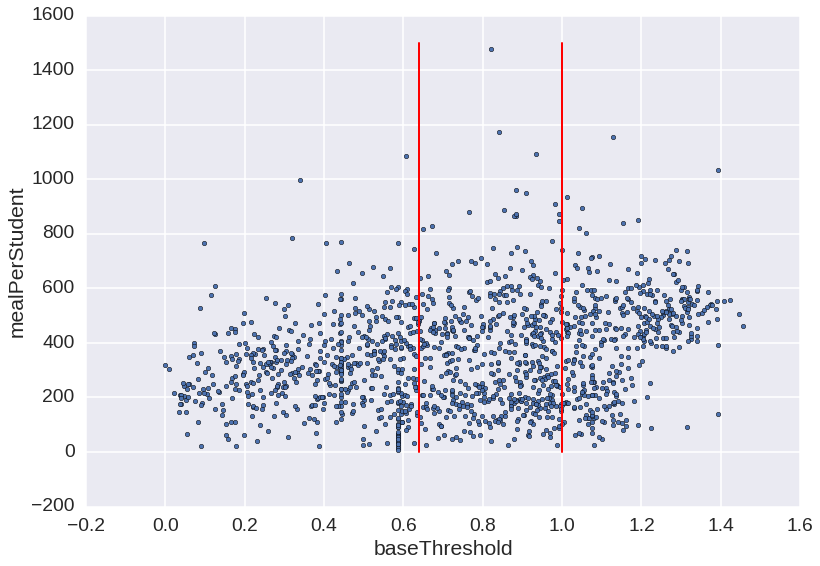

In [11]:
ax=cep.plot.scatter(x='baseThreshold',y='mealPerStudent')
#ax.annotate('group', xy=(.83, 980), xytext=(.9, 1100),
#            arrowprops=dict(facecolor='black', shrink=0.02))
#ax.annotate('', xy=(.94, 780), xytext=(.9, 1100),
#            arrowprops=dict(facecolor='black', shrink=0.02))
#ax.annotate('dont group', xy=(.65, 550), xytext=(.6, 690),
#            arrowprops=dict(facecolor='black', shrink=0.02))
#ax.annotate('', xy=(.75, 600), xytext=(.68, 670),
#            arrowprops=dict(facecolor='black', shrink=0.02))
plt.plot([t_min,t_min],[0,1500],'r-',lw=2)
plt.plot([1,1],[0,1500],'r-',lw=2)

The red lines in the plot above indicate the lower and upper bounds on the threshold groups. The lower bound 64% is determined by the CEP program and the upper bound is 100%. Any threshold above 100% is inefficient, but not prohibited.  

In [12]:
print 'maximum mealPerStudent (based on 180 days in a school year):',
deltaBreakfastRate*180 + deltaLunchRate*180 

maximum mealPerStudent (based on 180 days in a school year):

847.62

## Calculating Reimbursements based on school groupings

In [13]:
# all meals in the CEP program are reimbursed at a minimum at the paid rate
baseReimburse = paidLunch*cep.Lunch.sum() + paidBreakfast*cep.Breakfast.sum()

# reimbursements over the base, this is the part that's dependant on groupings

def calcReimburse(cep,cost=0):
    ''' calculates and returns the total reimbursments (above base) for schools in a particlar grouping 
    Parameters:
    cep: dataframe where each row is a school. cep columns include: Identified, Enrollment, meal, group
    cost: cost = 0 (default) no cost to dropping schools from the program
          cost = 1 sets a high penalty for letting a group go below the min threshold'''
    
    # df - each row represents a group
    group_cep = cep.groupby('group')
    df = pd.DataFrame(index= group_cep.indices)

    df['threshold'] =  (group_cep['Identified'].sum()  / group_cep['Enrollment'].sum()) * multiplier
    df['meal']      =  group_cep['meal'].sum()
    
    # enforcing threshold rules:
    df['applied_threshold'] = df['threshold']
    df.loc[df['applied_threshold']  > 1, 'applied_threshold'] = 1
    df.loc[df['applied_threshold']  < t_min,'applied_threshold'] = 0 - cost*10**6

    df['reimbursed'] = df['applied_threshold'] * df['meal']
    
    return df.reimbursed.sum()

def setThreshold(cep):
    ''' calculates the threshold for each school based on its group
        cep columns: Enrollment, Identified, threshold'''
    for i in set(cep.group):
        df = cep[cep.group==i]
        cep.loc[cep.group == i,'threshold'] = df['Identified'].sum() / float(df['Enrollment'].sum()) * multiplier
    return 0

In [14]:
print ' base reimbursement (all schools reimbursed at paid rate):',"{:e}".format(baseReimburse)

print '\n if all schools were reimbursed at 100% threshold (all at free rate)\n\
then this is the additional reimbursment:','{:e}'.format(cep.meal.sum())

 base reimbursement (all schools reimbursed at paid rate): 3.767395e+07

 if all schools were reimbursed at 100% threshold (all at free rate)
then this is the additional reimbursment: 2.434417e+08


In [15]:
results=[] #save reimbursement results

# put each school in it's own group
cep['group']=cep.index
results.append(calcReimburse(cep))
print "{:.2e}".format(results[-1])
cep.head()

1.43e+08


,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,1
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,2
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,3
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,4


In [16]:
# put all schools in a single group and calculate reimbursements
cep['group']=0
results.append(calcReimburse(cep))
print "{:.2e}".format(results[-1])
cep.head()

1.77e+08


,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,0
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,0
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,0
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,0


## Finding Maximum Reimbursements
## Method 1: Grouping by two
Start out with each school in it's own group. Calculate the reimbursement increase for each pair of groups.
Group together those with the highest reimbursement increase.

In [17]:
#def deltaReimburse(cep,group1,group2):
#    '''difference in reimbursement with combining groups vs separate
#    Paremeters:
#    cep: dataframe where each row is a school. cep columns include: Identified, Enrollment, meal, group
#    group1 and group2 - group names (ints) within cep that are to be combined or not
#    '''
#    df = cep[(cep['group'] == group1)|(cep['group'] == group2)].copy()
#    rseparate = calcReimburse(df) 
#    df.group=0
#    rcombined = calcReimburse(df) 

#    return rcombined - rseparate


In [18]:
# functions used in methods 1 and 2

def groupThreshold(cep):
    return cep.Identified.sum() / cep.Enrollment.sum() * multiplier

def groupReimburse(df):
    '''calculates reimbursements for df assuming all rows are in the same 'group'
    '''
    td = groupThreshold(df)
    if td>=t_min:
        return df['meal'].sum()*min(td,1)
    else:
        return 0

def deltaReimburse(df,group1,group2):
    '''difference in reimbursement with combining groups vs separate'''
    df12 = df[(df['group'] == group1)|(df['group'] == group2)].copy()
    r12 = groupReimburse(df12)

    df1 = df[df['group'] == group1].copy()
    r1 = groupReimburse(df1)
     
    df2 = df[df['group'] == group2].copy()
    r2 = groupReimburse(df2)

    return r12 - r1 - r2

In [19]:
cep1=cep.copy()
startTime = time.time()

#initialize deltaR
cep1['group']=cep1.index
index = list(set(cep1.group))
deltaR = pd.DataFrame(0,columns=index,index=index)

for i in index:
    for j in index:
        if i < j: #can probably optimize this
            deltaR.loc[i,j] = deltaReimburse(cep1,i,j)

while (deltaR.values.max() > 0):
    # the max value of deltaR, if it's >0, determines the groups to be combined
    # if max is <=0 then no further combination will increase reimbursements
    
    # the index and column location of the max value
    maxval = deltaR.values.max()
    indLoc = np.where(deltaR == maxval)[0][0] 
    colLoc = np.where(deltaR == maxval)[1][0]
    
    # the index location corresponds to the first group, the column location to the second group
    # note the firstGroup number is smaller than the secondGroup.
    firstGroup = index[indLoc]
    secondGroup = index[colLoc]
    
    #drop the row/col of the second group in deltaR (it will be combined with the first group)
    deltaR.drop(secondGroup,axis=0, inplace=True)
    deltaR.drop(secondGroup,axis=1,inplace=True)
    
    #combining groups in the school df
    cep1.loc[cep1.group==secondGroup,'group']=firstGroup
    
    #reset index
    index = list(set(cep1.group))
    #loop through the row of deltaR corresponding to the new grouping
    for i in index:
        if i>firstGroup:
            deltaR.loc[firstGroup,i] = deltaReimburse(cep1,firstGroup,i)

print 'time in h', (startTime-time.time())/60.0/60.0
results.append(calcReimburse(cep1))
print results[-1]
setThreshold(cep1)
deltaR

time in h -1.48148665057
177474283.598


,0,1,2,5,36
0,0,-1688.672076,-83627.182863,-1321.022980,-9.226194e+04
1,0,0.000000,-348362.989375,-323730.022652,-4.311346e+05
2,0,0.000000,0.000000,-534059.344169,-3.935008e+06
5,0,0.000000,0.000000,0.000000,-8.124284e+04
36,0,0.000000,0.000000,0.000000,0.000000e+00


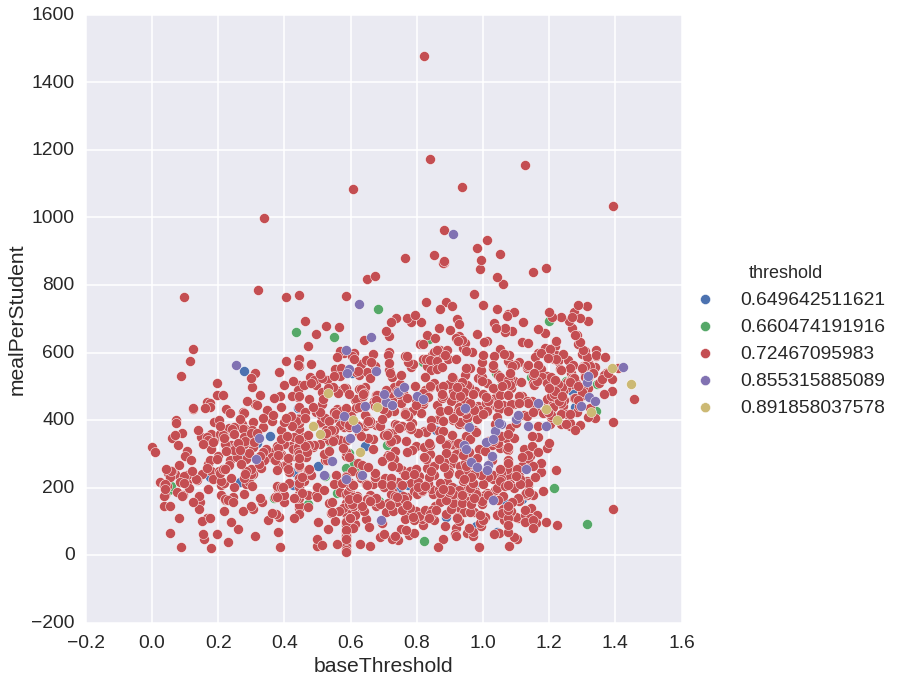

In [20]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cep1, hue='threshold',
             size=10,plot_kws={'s':100})

In [21]:
pd.concat([cep1.groupby('threshold').count()[['School']],
           cep1.groupby('threshold').sum()[['Enrollment']],
           cep1.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.649643,31,21189.500000,274.325998
0.660474,34,25707.872093,357.514031
0.724671,1323,645744.349723,356.148363
0.855316,54,29082.244186,411.231727
0.891858,11,4790.000000,425.769547


## Method 2: ungrouping one by one
Start with all schools in one group and take out ones if they increase reimbursement

*  2a remove schools with baseThreshold less than the group threshold
* 2b remove shcools with baseThreshold greater than the group threshold

In [22]:
cep2a = cep.copy()
startTime = time.time()

#start out with all schools in one group
cep2a.group = 0

# prune down the large group in a way that increases reimbursements and raises the 
# threshold of the group (t0) until it reaches a max of 1
# for all schools that have been pruned out (ungrouped), regroup them into their
# own group and redo the pruning process on that group
# keep doing this until there are no more schools left to be pruned out.
count=1
prune = cep2a.copy()
while(prune.shape[0]>1):
    ungroup = []
    t0 = groupThreshold(prune)
    while(t0<1):
        # deltaR is the cost to ungroup a single school (indexed by index) from the rest of the group
        index = prune[prune.baseThreshold<t0].index
        deltaR = pd.Series(0,index=index)
        for i in index:
            prune.group = 0
            prune.loc[i,'group'] = 1
            deltaR.loc[i] = deltaReimburse(prune,1,0)
        #take out the school with the least cost (most gain) and redo the whole thing
        #unless the cost is positive, in which case end
        if (deltaR.min()<0):
            ungroup.append(deltaR.idxmin())
            prune.drop(deltaR.idxmin(),inplace=True)
            t0 = groupThreshold(prune)
        else:
            break

    #set the school group in the cep, for those that were just "ungrouped"
    cep2a.loc[cep2a.index.isin(ungroup),'group']=count
    calcReimburse(cep2a)
    #redo the pruning proces with those schools.
    prune = cep2a[cep2a.group==count].copy()
    count += 1 
results.append(calcReimburse(cep2a))
setThreshold(cep2a)

print 'time in h', (startTime-time.time())/60.0/60.0
print results[-1]

time in h -0.142109473877
169723875.181


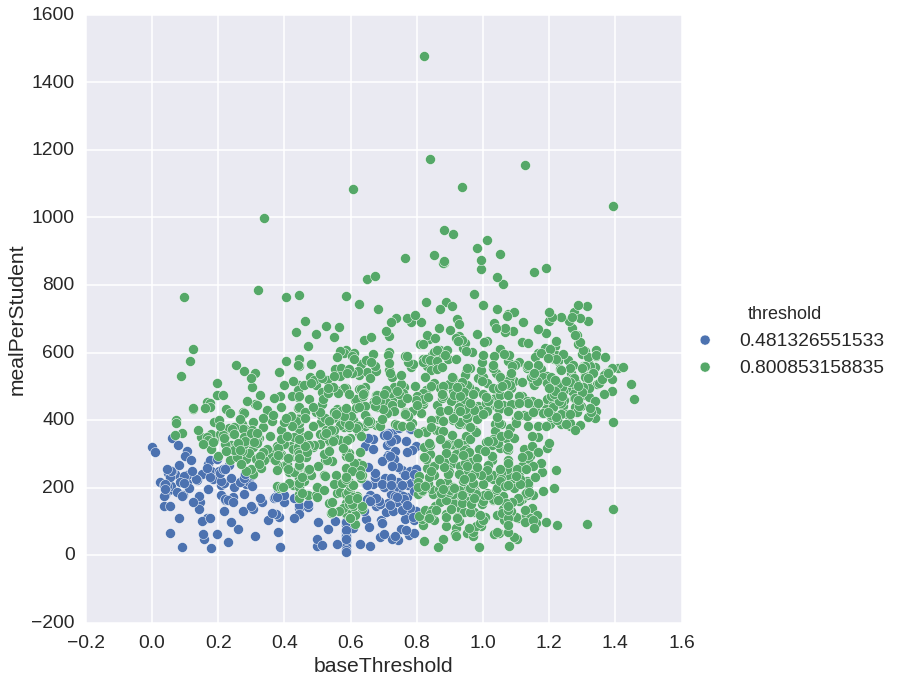

In [23]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cep2a, hue='threshold',
             size=10,plot_kws={'s':100})

In [24]:
pd.concat([cep2a.groupby('threshold').count()[['School']],
           cep2a.groupby('threshold').sum()[['Enrollment']],
           cep2a.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.481327,259,168960.375083,177.047403
0.800853,1194,557553.590919,396.045702


method 2b

In [25]:
cep2b = cep.copy()
startTime = time.time()

#start out with all schools in one group
cep2b.group = 0
calcReimburse(cep2b)

# prune down the large group in a way that increases reimbursements and lowers the 
# threshold of the group (t0), until it reaches the lower limit t_min
# for all schools that have been pruned out (ungrouped), regroup them into their
# own group and redo the pruning process on that group
# keep doing this until there are no more schools left to be pruned out.
count=1
prune = cep2b.copy()
while(prune.shape[0]>1):
    ungroup = []
    t0 = groupThreshold(prune)
    while(t0>=t_min):
        # deltaR is the cost to ungroup a single school (indexed by index) from the rest of the group
        index = prune[prune.baseThreshold>t0].index
        deltaR = pd.Series(0,index=index)
        for i in index:
            prune.group = 0
            prune.loc[i,'group'] = 1
            deltaR.loc[i] = deltaReimburse(prune,1,0)
        #take out the school with the least cost (most gain) and redo the whole thing
        #unless the cost is positive, in which case end
        if (deltaR.min()<0):
            prune.drop(deltaR.idxmin(),inplace=True)
            t0 = groupThreshold(prune)
            if(t0>=t_min):
                ungroup.append(deltaR.idxmin())
        else:
            break

    #set the school group in the cep, for those that were just "ungrouped"
    cep2b.loc[cep2b.index.isin(ungroup),'group']=count
    calcReimburse(cep2b)
    #redo the pruning proces with those schools.
    prune = cep2b[cep2b.group==count].copy()
    count += 1 
results.append(calcReimburse(cep2b))
setThreshold(cep2b)

print 'time in h', (startTime-time.time())/60.0/60.0
print results[-1]

time in h -0.24784352945
187887201.81


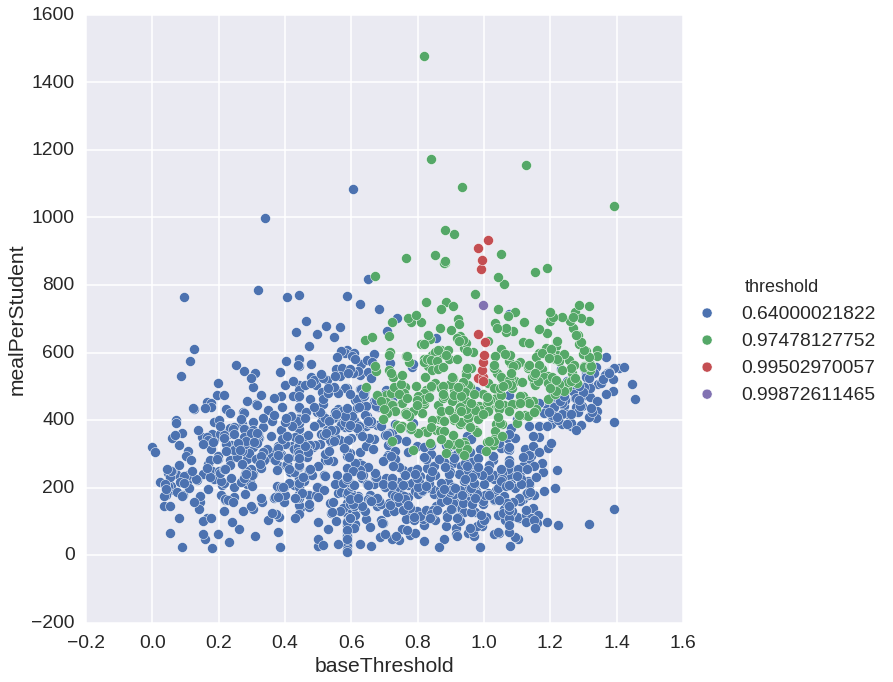

In [26]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cep2b, hue='threshold',
             size=10,plot_kws={'s':100})

In [27]:
pd.concat([cep2b.groupby('threshold').count()[['School']],
           cep2b.groupby('threshold').sum()[['Enrollment']],
           cep2b.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640000,1060,538983.466002,289.886175
0.974781,380,183013.500000,533.105012
0.995030,12,4124.500000,677.736182
0.998726,1,392.500000,741.761475


In [28]:
results

[143230309.26542294,
 176870910.15046152,
 177474283.59752318,
 169723875.18091002,
 187887201.81044886]

## Method 3: Monte Carlo -- stochastic hill climbing

In [63]:
def montecarlo(cep, ngroups = 10, attempts=10**3):
    startTime = time.time()

    # store the results
    results=[]
    results.append(calcReimburse(cep))
    temp = []
    rows=cep.shape[0]

    # mc loop
    while(len(temp) < attempts):
        df = cep.copy()
        # choose a random school and move it to a different random group
        df.loc[np.random.randint(0,rows),'group'] = np.random.randint(0,ngroups)
                                                                                   
        # calculate the reimbursement
        temp.append(calcReimburse(df,cost=1))
        #step = temp[-1] - results[-1]                                                                           
            
        #keep move if reimbursement increases
        if (temp[-1] > results[-1]):
            results.append(temp[-1])
            cep.group = df.group
            temp=[]
                   
    print results[-1]
    print 'time in h', (time.time() - startTime)/60.0/60.0
    return results , cep
 

In [64]:
cepmc=cep.copy()

# start by grouping schools randomly into 10 groups
ngroups=10
seed = 42
np.random.seed(seed)
rows=cepmc.shape[0]
cepmc['group'] = pd.Series(np.random.randint(0,ngroups,size=rows))
# run mc
mc, cepmc = montecarlo(cepmc,attempts=10**5)
setThreshold(cepmc)

187327901.123
time in h 0.227065417237


0

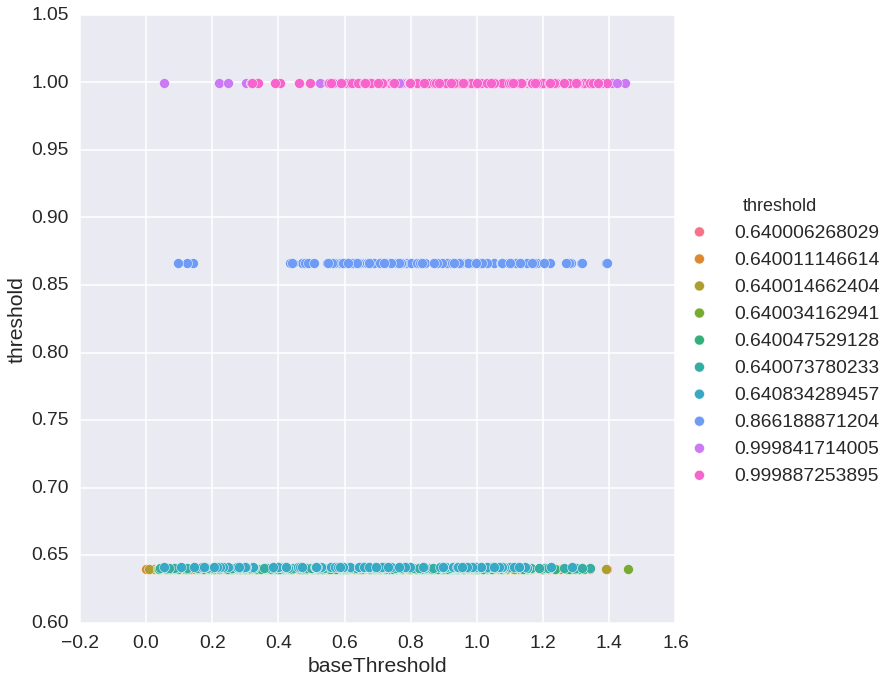

In [31]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cepmc, hue='threshold',
             size=10,plot_kws={'s':100})

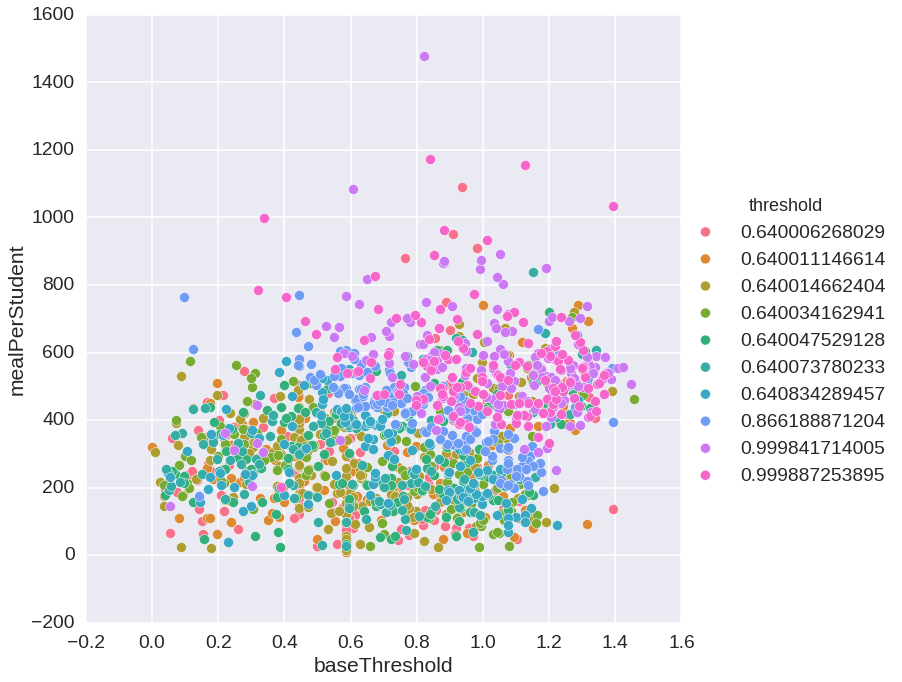

In [32]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cepmc, hue='threshold',
             size=10,plot_kws={'s':100})

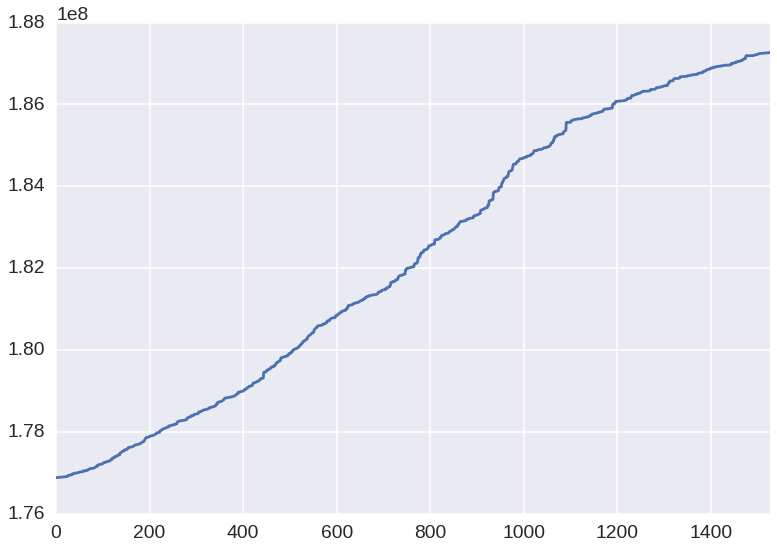

In [33]:
pd.Series(mc).plot()

In [34]:
pd.concat([cepmc.groupby('threshold').count()[['School']],
           cepmc.groupby('threshold').sum()[['Enrollment']],
           cepmc.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640006,154,65158.667774,270.051667
0.640011,137,71455.933223,278.665286
0.640015,183,101180.722924,280.525519
0.640034,135,74935.000000,283.855827
0.640048,131,71841.705426,280.272881
0.640074,123,76657.577519,292.815863
0.640834,119,66675.500000,292.774097
0.866189,162,64838.487043,428.168559
0.999842,169,70501.372093,560.293778


In [70]:
results.append(calcReimburse(cepmc))
results

[143230309.26542294,
 176870910.15046152,
 177474283.59752318,
 169723875.18091002,
 187887201.81044886,
 187327901.12296268]

## 3a
Instead of seading with 10 random groups, start with every school in a single group. Then run monte carlo.

In [36]:
cepmc = cep.copy()

# start by putting all schools into a single group
cepmc['group'] = 0

# run mc
mc, cepmc = montecarlo(cepmc,attempts=10**6)
setThreshold(cepmc)

188170513.277
time in h 1.26124412974


0

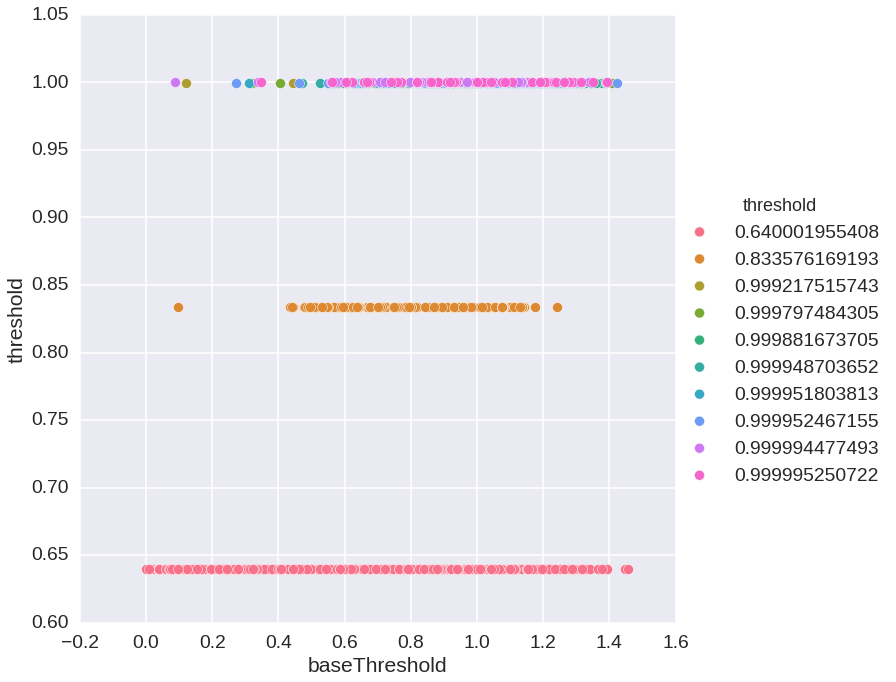

In [37]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cepmc, hue='threshold',
             size=10,plot_kws={'s':100})

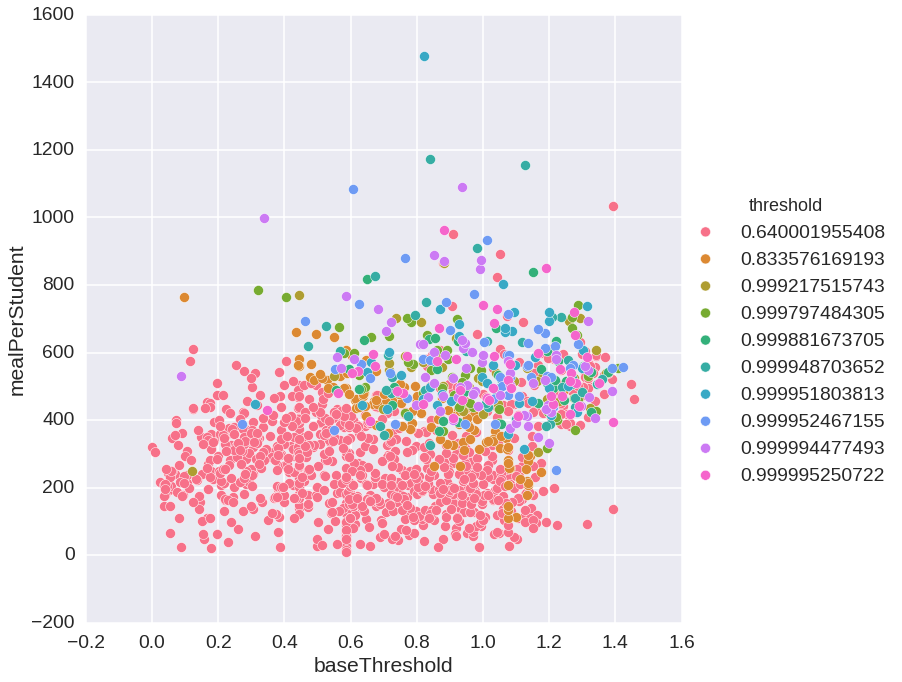

In [38]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cepmc, hue='threshold',
             size=10,plot_kws={'s':100})

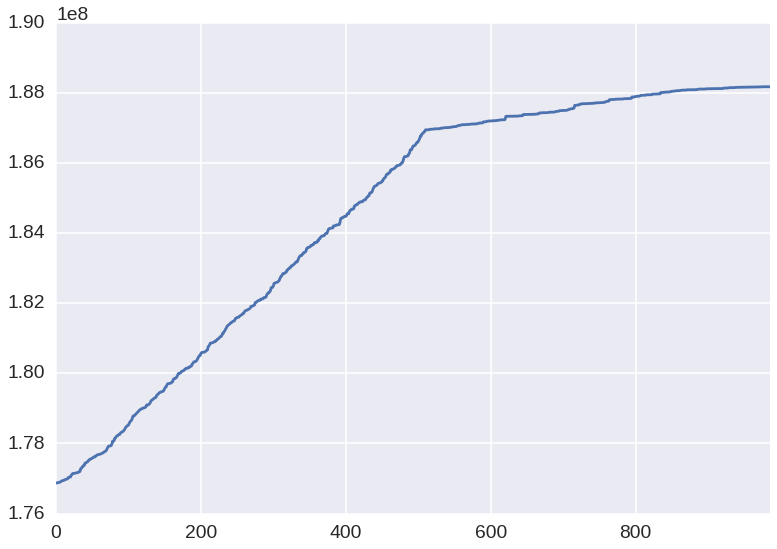

In [39]:
pd.Series(mc).plot()

In [40]:
pd.concat([cepmc.groupby('threshold').count()[['School']],
           cepmc.groupby('threshold').sum()[['Enrollment']],
           cepmc.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640002,973,531269.440199,276.695369
0.833576,117,44426.906091,407.256444
0.999218,36,14784.414286,543.683690
0.999797,52,22220.500000,539.958871
0.999882,35,16339.000000,540.357410
0.999949,39,14945.833333,572.560902
0.999952,44,18812.000000,566.107608
0.999952,48,15007.166667,577.242024
0.999994,64,27652.872093,559.801996


## Method 4: Monte Carlo -- simulated annealing
similar to stochastic hill climbing, but allows downwards steps as well

In [58]:
def simulated_annealing(cep, seed=None, ngroups=10, Tmax=10, deltaT=0.1):
    startTime = time.time()

    # start by grouping schools randomly
    np.random.seed(seed)
    rows=cep.shape[0]
    cep['group'] = pd.Series(np.random.randint(0,ngroups,size=rows))

    # store the results
    results=[]
    results.append(calcReimburse(cep))

    # mc loop
    for T in np.arange(Tmax,0,-deltaT):
        for i in range(1000):
            df = cep.copy()
            
            # choose a random school and move it to a different random group
            df.loc[np.random.randint(0,rows),'group'] = np.random.randint(0,ngroups)
                                                                                   
            # calculate the reimbursement
            temp = calcReimburse(df,cost=1)
            step = temp - results[-1]                                                                           
            
            #keep move if reimbursement increases
            if (step > 0):
                results.append(temp)
                cep.group = df.group
                
            #maybe keep move if reimbursement decreases, depending on how much
            elif (np.random.uniform() < np.exp(step/T)):
                results.append(temp)
                cep.group = df.group
                
    print results[-1]
    print 'time in h', (time.time() - startTime)/60.0/60.0
    return results , cep


In [59]:
cepsa=cep.copy()
sa, cepsa = simulated_annealing(cepsa)
setThreshold(cepsa)

187394350.076
time in h 0.117622639471


0

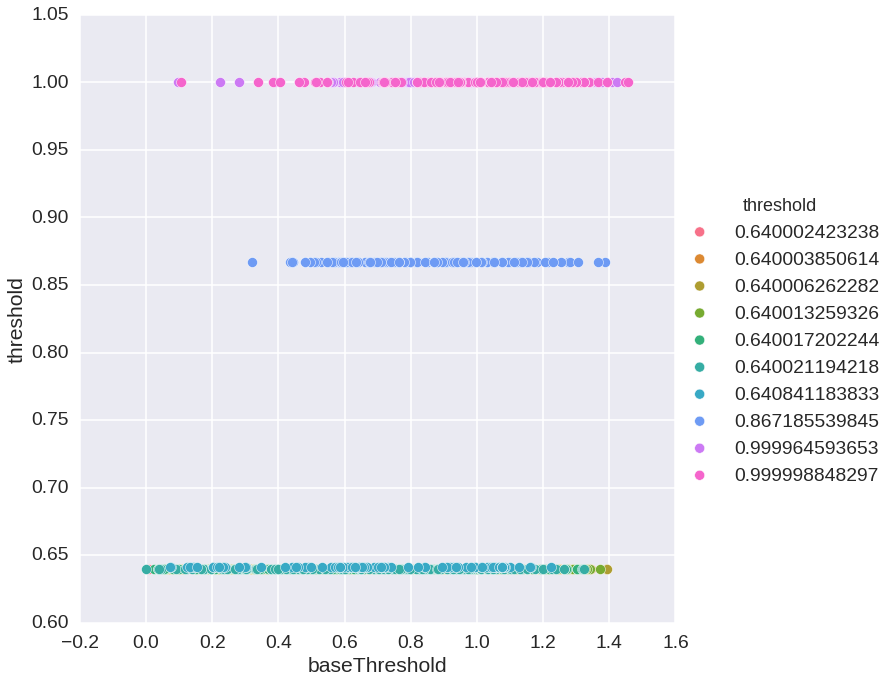

In [60]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cepsa, hue='threshold',
             size=10,plot_kws={'s':100})

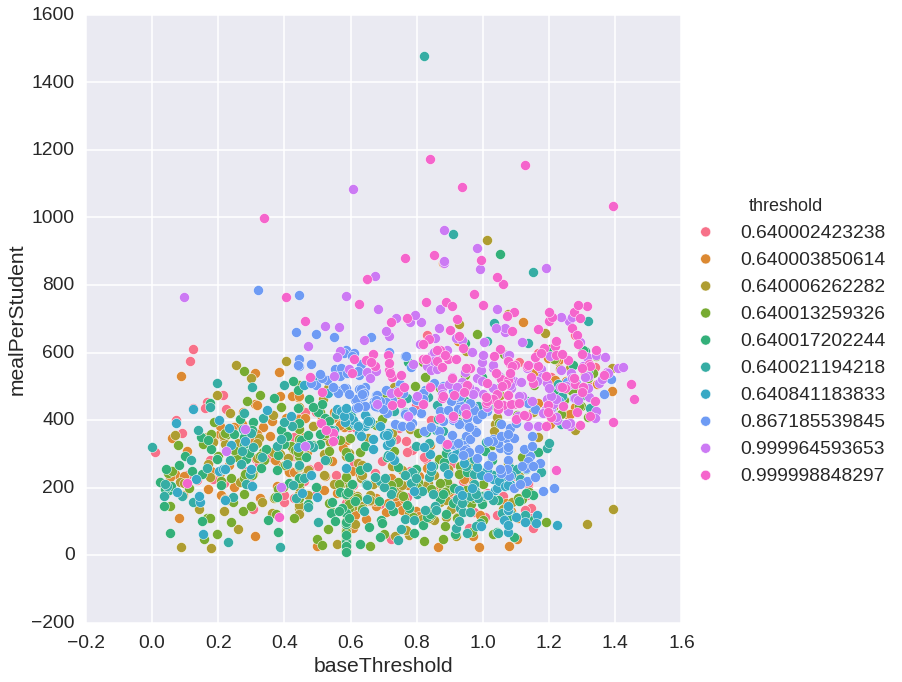

In [61]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cepsa, hue='threshold',
             size=10,plot_kws={'s':100})

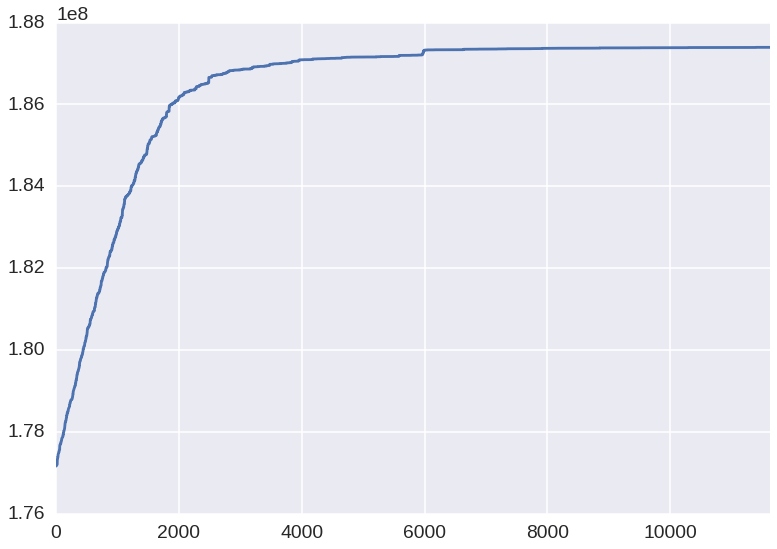

In [62]:
pd.Series(sa).plot()

In [65]:
pd.concat([cepsa.groupby('threshold').count()[['School']],
           cepsa.groupby('threshold').sum()[['Enrollment']],
           cepsa.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640002,118,61508.533998,275.106423
0.640004,153,77121.637320,293.463230
0.640006,159,79575.015393,266.531026
0.640013,158,83995.789701,277.230154
0.640017,149,89851.010742,269.295953
0.640021,142,87786.747619,304.944166
0.640841,97,42861.705426,277.269680
0.867186,177,79339.487043,428.075019
0.999965,145,60800.205426,556.646528


In [71]:
results.append(calcReimburse(cepsa))
results

[143230309.26542294,
 176870910.15046152,
 177474283.59752318,
 169723875.18091002,
 187887201.81044886,
 187327901.12296268,
 187394350.07642767]

## Upper Bound
for each school, calculate the largest threshold it could have. Use this to determine upper bound on reimbursements.

###Need to recheck this code.

In [72]:
def calcBounds(cep):
    '''calculate upper and lower bounds to reimbursements'''
    cep['group'] = cep.index
    setThreshold(cep)     
    for i in cep.index.values:
        cep.group = cep.index
        #define tgroup to hold original threshold values, drop one by one highest to lowest
        tgroup = cep.threshold.copy()
        # initialize the new threshold
        newt = cep.loc[i].threshold 
        while (newt < tgroup.max()) and (newt<1):
            #combine the group with the maximum threshold with group i
            #calculate the new threshold of that combined group
            #new indicies to include in threshold calculation
            newIndex = tgroup[tgroup==tgroup.max()].index
            dftemp = cep[(cep.group==i)|\
                             (cep.index.isin(newIndex))].copy()
            #calculate new threshold
            newnewt = dftemp['Identified'].sum() / float(dftemp['Enrollment'].sum())*multiplier
            if newnewt<1:
                #only save this group if the new value of the threshold is<1
                cep.loc[newIndex,'group']=i
                # drop tmax from group and start over
                tgroup.drop(newIndex,inplace=True)
                newt=newnewt
            else:
                break        
        #store the max threshold tmax, and the groupings that made it gmax.
        cep.loc[i,'tmax'] = newt
        #cep.loc[i,'gmax'] = ','.join(str(x) for x in (cep[cep.group==i].index.values))
    
    cep['rmax'] = cep['meal']*(cep['tmax'].apply(lambda x:min(x,1)))
    #cep['rover'] = cep['meal']*cep['tmax'] - cep['rmax']


In [73]:
sbounds = cep.copy()
calcBounds(sbounds)

print "{:2e}".format(sbounds.rmax.sum())

2.246212e+08


In [74]:
sbounds.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group,threshold,tmax,rmax
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0,0.680597,0.680597,79816.510169
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,1,1.029787,1.029787,30529.287474
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,2,1.204598,1.204598,147700.374114
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,3,0.690427,0.984392,69659.249518
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,4,0.544330,0.544330,44206.607002


In [75]:
print baseReimburse
print sbounds.rmax.sum() + baseReimburse

37673952.1221
262295183.803


In [76]:
# adding in baseline reimbursements to get total
results = results + baseReimburse
results

array([  1.80904261e+08,   2.14544862e+08,   2.15148236e+08,
         2.07397827e+08,   2.25561154e+08,   2.25001853e+08,
         2.25068302e+08])

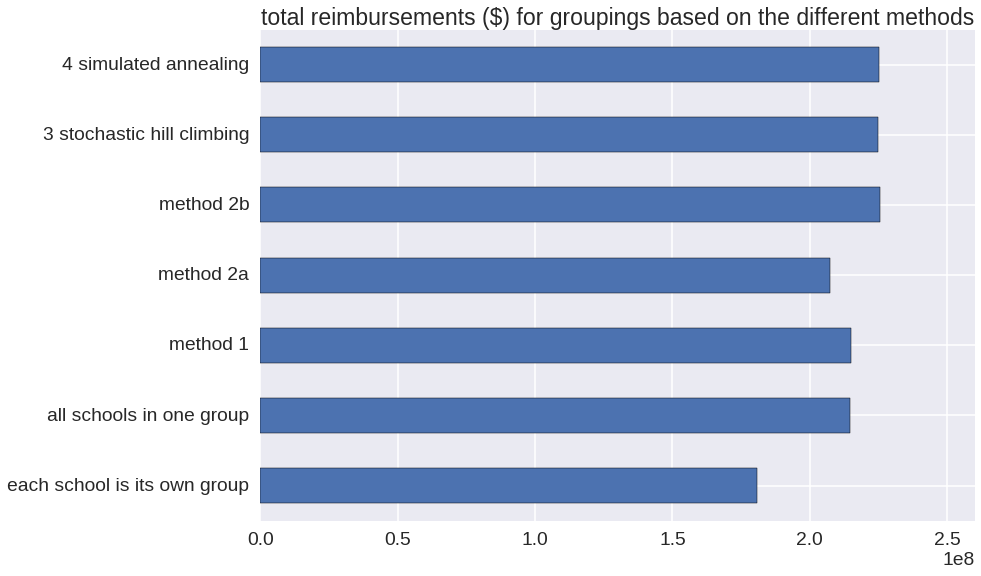

In [77]:
rs = pd.Series(results, index=['each school is its own group','all schools in one group',
                          'method 1',
                          'method 2a','method 2b',
                          '3 stochastic hill climbing','4 simulated annealing'])
rs.plot(kind='barh',title='total reimbursements ($) for groupings based on the different methods',
        xlim=(0,2.6*10**8))

In [80]:
print 'increase in reimbursement $', '{:,}'.format(round(rs['3 stochastic hill climbing'] - rs['all schools in one group'],-4))

increase in reimbursement $ 10,460,000.0


##Results Summary:
We tried 5 different methods of finding the groupings that maximize reimbursements. This was in addition to the baseline approaches of putting each school in it's own group and putting all schools into a single group.

Putting each school into it's own group falls short because many schools don't reach the minimum threshold (64%). Those schools then don't receive any reimbursements.

Putting alls schools into one group gives a reimbursement of $2.15 million.

The stochastic approaches (hill climbing and simulated annealing) both yield similar results to method 2b. \$2.25 million. An increase of over \$10 million.

## save to csv file

In [140]:
pd.concat([cep3.groupby('group').count()[['School']],
           cep3.groupby('group').sum()[['Enrollment']],
           cep3.groupby('group').mean()[['threshold']]],axis=1).sort_values('threshold')

,School,Enrollment,threshold
group,,,
6,159,88295.933112,0.640006
5,93,47357.666667,0.640010
7,171,81721.386157,0.640010
8,133,63798.009413,0.640014
3,128,81450.281617,0.640015
2,135,75598.205426,0.640039
9,151,78931.372093,0.640133
1,174,76002.239424,0.835371
4,168,73552.166667,0.999995


In [149]:
#combine groups which are similar
cepfinal=cep3.copy()
cepfinal.loc[cepfinal.threshold<.65,'group']=1
cepfinal.loc[(cepfinal.threshold>.65)&(cepfinal.threshold<.9),'group']=2
cepfinal.loc[cepfinal.threshold>.9,'group']=3


In [150]:
pd.concat([cepfinal.groupby('group').count()[['School']],
           cepfinal.groupby('group').sum()[['Enrollment']],
           cepfinal.groupby('group').mean()[['threshold']]],axis=1).sort_values('threshold')

,School,Enrollment,threshold
group,,,
1,970,517152.854485,0.640034
2,174,76002.239424,0.835371
3,309,133358.872093,0.999996


In [151]:
calcReimburse(cepfinal)

187508387.56326836

In [152]:
#merge onto original doe and save to file
doefinal = doe.merge(cepfinal[['School','group']],how='left',on='School')
doefinal.to_csv('SchoolGroups.csv')